In [1]:
# %% Imports
import copy
from visualization import *
unique_id = "34fec7e871b14fdcac5db6dfb944be16"
unique_id = "fc269f147f7349de84013c2251e26a15"

save_ext = 'seed'
save_ext = 'finetune/seed'
suffix = None

In [2]:
config = recover_config(unique_id, save_ext=save_ext, suffix=suffix)
vocab_size = config["vocab_size"]
length = config["seq_length"]
sparsity_index = config["sparsity_index"]
ffn_dim = config["ffn_dim"]
assert config["save_weights"], f"Weights were not saved for ID {unique_id}."

save_dir, _ = get_paths(save_ext, suffix=suffix)
save_dir = save_dir / unique_id
weights = pickle.load(open(save_dir / "weights.pkl", "rb"))
losses = pickle.load(open(save_dir / "losses.pkl", "rb"))
test_losses = pickle.load(open(save_dir / "test_losses.pkl", "rb"))
accs = pickle.load(open(save_dir / "accs.pkl", "rb"))
test_accs = pickle.load(open(save_dir / "test_accs.pkl", "rb"))

DEVICE = "cpu"

# modules

config = ModelConfig(
    vocab_size=config["nb_emb"],
    emb_dim=config["emb_dim"],
    seq_length=config["seq_length"],
    ffn_dim=config["ffn_dim"],
    ffn_bias=config["ffn_bias"],
)
model = Model(config)
model.eval()
model.to(DEVICE)
norm = RMSNorm()

# variables

kwargs = {
    "DEVICE": DEVICE,
    "vocab_size": vocab_size,
    "sparsity_index": sparsity_index,
    "length": length,
    "ffn_dim": ffn_dim,
    "losses": losses,
    "test_losses": test_losses,
    "accs": accs,
    "test_accs": test_accs,
    "text_fontsize": 8,
    "title_fontsize": 12,
    "pos_marker": "o",
    "neg_marker": "s",
    "third_marker": "^",
}


# plot configurations

plot_functions = {
    "show_token_emb": show_token_emb,
    "show_pos_emb": show_pos_emb,
    "show_emb": show_emb,
    "show_norm_emb": show_norm_emb,
    "show_attn": show_attn,
    "show_value": show_value,
    "show_seq_emb": show_seq_emb,
    "show_level_line": show_level_line,
    "show_norm_input": show_norm_input,
    "show_mlp_receptors": show_mlp_receptors,
    "show_mlp_emitters": show_mlp_emitters,
    "show_mlp_output": show_mlp_output,
    "show_output_level_lines": show_output_level_lines,
    "show_output": show_output,
    "show_loss": show_loss,
    "show_acc": show_acc,
}



In [23]:
pos_seq_embs = []
neg_seq_embs = []
third_seq_embs = []
norm_pos_seqs = []
norm_neg_seqs = []
pos_seq_mlps = []
neg_seq_mlps = []

# for i, frame in enumerate([643, 644, 645]):
for i, frame in enumerate([810, 811, 812]):
    model.load_state_dict(weights[frame])
    variables = ComputationCache(
        {
            "weights": weights[frame],
            "model": model,
            "norm": norm,
            "frame": frame,
        }
        | kwargs
    )
    if i == 1:
        x_min = variables["mlp_x_min"]
        x_max = variables["mlp_x_max"]
        y_min = variables["mlp_y_min"]
        y_max = variables["mlp_y_max"]
        out_mlp = variables["out_mlp"]
    pos_seq_embs.append(variables["pos_seq_emb"])
    neg_seq_embs.append(variables["neg_seq_emb"])
    third_seq_embs.append(variables["third_seq_emb"])
    norm_pos_seqs.append(variables["norm_pos_seq"])
    norm_neg_seqs.append(variables["norm_neg_seq"])
    pos_seq_mlps.append(variables["pos_seq_mlp"])
    neg_seq_mlps.append(variables["neg_seq_mlp"])

Text(0.5, 1.0, '$\\Delta\\sum \\sigma(w_i^\\top \\xi / \\|\\xi\\| + b_i)$')

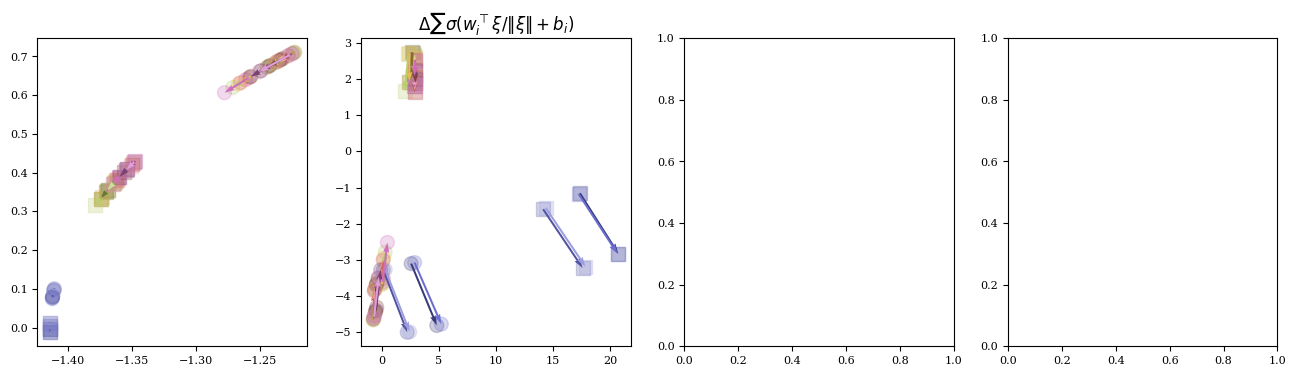

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
tab20 = plt.get_cmap("tab20b")

ax = axes[0]
for i in range(2):
    ax.scatter(
        norm_pos_seqs[i][:, 0],
        norm_pos_seqs[i][:, 1],
        marker=kwargs["pos_marker"],
        c=np.arange(pos_seq_mlps[i].shape[0]),
        cmap="tab20b",
        s=100,
        alpha=.25,
    )
    ax.scatter(
        norm_neg_seqs[i][:, 0],
        norm_neg_seqs[i][:, 1],
        marker=kwargs["neg_marker"],
        c=np.arange(neg_seq_mlps[i].shape[0]),
        cmap="tab20b",
        s=100,
        alpha=.25,
    )
x1, y1 = norm_pos_seqs[0].T
x2, y2 = norm_pos_seqs[1].T
dx, dy = x2 - x1, y2 - y1
ax.quiver(x1, y1, dx, dy, angles="xy", scale_units="xy", scale=1, color=[tab20(i) for i in range(len(x1))])
x1, y1 = norm_neg_seqs[0].T
x2, y2 = norm_neg_seqs[1].T
dx, dy = x2 - x1, y2 - y1
ax.quiver(x1, y1, dx, dy, angles="xy", scale_units="xy", scale=1, color=[tab20(i) for i in range(len(x1))])

ax = axes[1]
for i in range(2):
    ax.scatter(
        pos_seq_mlps[i][:, 0],
        pos_seq_mlps[i][:, 1],
        marker=kwargs["pos_marker"],
        c=np.arange(pos_seq_mlps[i].shape[0]),
        cmap="tab20b",
        s=100,
        alpha=.25,
    )
    ax.scatter(
        neg_seq_mlps[i][:, 0],
        neg_seq_mlps[i][:, 1],
        marker=kwargs["neg_marker"],
        c=np.arange(pos_seq_mlps[i].shape[0]),
        cmap="tab20b",
        s=100,
        alpha=.25,
    )
ax.set_title(r"$\Delta \frac{\xi}{\|\xi\|})$", fontsize=kwargs["title_fontsize"])

x1, y1 = pos_seq_mlps[0].T
x2, y2 = pos_seq_mlps[1].T
dx, dy = x2 - x1, y2 - y1
ax.quiver(x1, y1, dx, dy, angles="xy", scale_units="xy", scale=1, color=[tab20(i) for i in range(len(x1))])
x1, y1 = neg_seq_mlps[0].T
x2, y2 = neg_seq_mlps[1].T
dx, dy = x2 - x1, y2 - y1
ax.quiver(x1, y1, dx, dy, angles="xy", scale_units="xy", scale=1, color=[tab20(i) for i in range(len(x1))])
ax.set_title(r"$\Delta\sum \sigma(w_i^\top \xi / \|\xi\| + b_i)$", fontsize=kwargs["title_fontsize"])

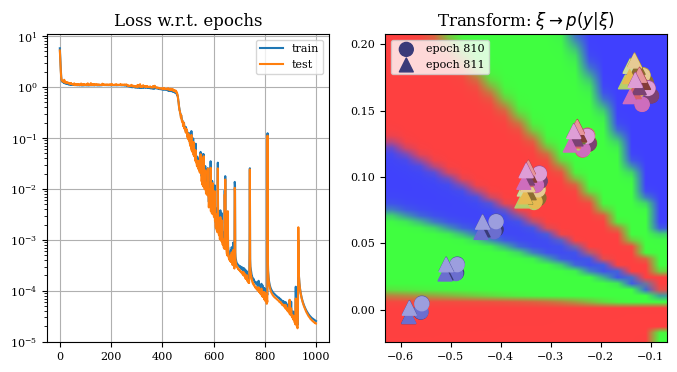

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(2 * 4, 4))

ax = axes[1]
ax.imshow(
    out_mlp.transpose(0, 1),
    extent=(x_min, x_max, y_min, y_max),
    interpolation="bilinear",
    alpha=0.75,
    origin="lower",
    aspect="auto",
)

for i in range(2):
    marker = {
        0: kwargs["pos_marker"],
        1: kwargs["third_marker"],
        2: kwargs["neg_marker"],
    }[i]
    ax.scatter(
        pos_seq_embs[i][:, 0], 
        pos_seq_embs[i][:, 1], 
        marker=marker,
        s=100, 
        c=np.arange(pos_seq_mlps[i].shape[0]),
        cmap="tab20b",
        label="epoch " + str(810 + i)
    )
    ax.scatter(
        neg_seq_embs[i][:, 0], 
        neg_seq_embs[i][:, 1], 
        marker=marker,
        s=100, 
        c=np.arange(pos_seq_mlps[i].shape[0]),
        cmap="tab20b",
    )
    ax.scatter(
        third_seq_embs[i][:, 0], 
        third_seq_embs[i][:, 1], 
        marker=marker,
        s=100, 
        c=np.arange(pos_seq_mlps[i].shape[0]),
        cmap="tab20b",
    )
ax.set_title(r"Transform: $\xi \to p(y|\xi)$", fontsize=kwargs["title_fontsize"])
ax.legend(fontsize=kwargs["text_fontsize"])

ax = axes[0]
ax.plot(losses, label="train")
ax.plot(test_losses, label="test")
ax.set_yscale("log")
ax.grid()
ax.set_title("Loss w.r.t. epochs", fontsize=kwargs["title_fontsize"])
ax.legend(fontsize=kwargs["text_fontsize"])
fig.savefig("loss_spike_finetune.pdf", bbox_inches="tight")